<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 5 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 11 October 2018, with material from Philip Lewis, Department of Geography - University College London</div>

# Lab: Modeling Rainfall with the $\gamma$ distribution

Let's practice what we learned last lecture. Let's build a Bayesian model for a dataset, so we can extract precise statistics from the model itself, rather than the data. We'll look at the histogram of the data, pick an analytic model matching the shape of the histogram, model its parameters (priors) as pdfs, play around with the shape and values of these parameters (these are called *hyperparameters*), until we find a good shape and initial values. Run a probabilistic program to give us the posterior pdfs, then plot the posterior means on top of the histogram and check if we get a good match.

Let's model rainfall data per calendar month for the city of Nashville, Tennessee. RAinfall data is a great opportunity to introduce a new useful pdf: the $\gamma$ distribution. 

</br >
<center>
<img src="ipynb.images/rainfall.jpeg" width=400 />
</center>



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## 1. The $\gamma$ distribution

This is the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution):

<div style="font-size: 120%;">  
$$f(x) = \frac{\beta^\alpha x^{\alpha -1} e^{- \beta x}}{\Gamma (\alpha)}$$
</div>

Wooow.. what is the $\Gamma()$ function? It [interpolates](https://en.wikipedia.org/wiki/Gamma_function) the factorial function to non-integer values. WE already learned about it when we learned about the $\beta$ distribution.

for $x > 0$ and $\alpha, \beta > 0$

</br >
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Gamma_distribution_pdf.svg" width="500" />
Gamma distribution
</center>

## 2. Dataset: Nashville Precipitation

The dataset `nashville_precip.txt` contains NOAA precipitation data for Nashville measured since 1871. Download it from blackboard and put it in the right folder (`C:/Users/<username>/data`). 
    
The $\gamma$ distribution happens to be a good fit to aggregated rainfall data, and will be our candidate distribution in this case. 

Let's peek at the data:

In [2]:
precip = pd.read_table("data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


Let's do some data exploration..

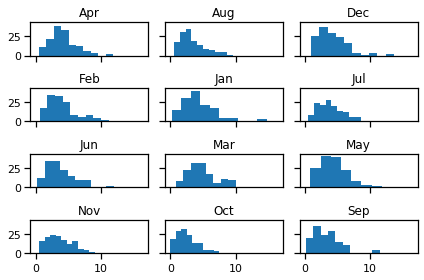

In [3]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

The first step is recognizing what sort of distribution to fit our data to. A couple of observations:

1. The data is *skewed*, with a longer tail to the right than to the left
2. The data is *positive-valued*, since they are measuring rainfall
3. The data is *continuous*

There are a few possible choices, but a good option is the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution):

<div style="font-size: 120%;">  
$$x \sim \text{Gamma}(\alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$
</div>

The gamma distribution used to model the size of [insurance claims](https://www.crcpress.com/Statistical-and-Probabilistic-Methods-in-Actuarial-Science/Boland/p/book/9781584886952) and [rainfalls](http://journals.tubitak.gov.tr/engineering/issues/muh-00-24-6/muh-24-6-7-9909-13.pdf). This means that aggregate insurance claims and the amount of rainfall accumulated in a reservoir are modelled by a gamma process – much like the exponential distribution generates a Poisson process, as we saw a few lectures ago.


## 3. Data Cleansing 

Wait a sec.. There's something wrong with our data.. if you open it in a text editor, you will find a value of NA for October of 1963 (tke a look). So we have to do some data cleansing first (remember the first step in data science from Lecture 1?). Given what we are trying to do, it is sensible to fill in the missing value with the average of the available values (another option would have been the average of the months of September and November 1963).


In [4]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)
precip

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30
...,...,...,...,...,...,...,...,...,...,...,...,...
2007,3.32,1.84,2.26,2.75,3.30,2.37,1.47,1.38,1.99,4.95,6.20,3.83
2008,4.76,2.53,5.56,7.20,5.54,2.21,4.32,1.67,0.88,5.03,1.75,6.72
2009,4.59,2.85,2.92,4.13,8.45,4.53,6.03,2.14,11.08,6.49,0.67,3.99


## 4. Exploration

Let's calculate the means and variances of precipitation, by month:

In [5]:
precip_mean = precip.mean()
precip_mean

Jan    4.523688
Feb    4.097801
Mar    4.977589
Apr    4.204468
May    4.325674
Jun    3.873475
Jul    3.895461
Aug    3.367305
Sep    3.377660
Oct    2.610500
Nov    3.685887
Dec    4.176241
dtype: float64

In [6]:
precip_var = precip.var()
precip_var

Jan    6.928862
Feb    5.516660
Mar    5.365444
Apr    4.117096
May    5.306409
Jun    5.033206
Jul    3.777012
Aug    3.779876
Sep    4.940099
Oct    2.741659
Nov    3.679274
Dec    5.418022
dtype: float64

In [7]:
precip.Apr

Year
1871     4.13
1872     5.91
1873     3.59
1874    11.84
1875     4.22
        ...  
2007     2.75
2008     7.20
2009     4.13
2010     3.48
2011     7.51
Name: Apr, Length: 141, dtype: float64

Ok, so let's pick pdfs for the $\gamma$ distribution's parameters $\alpha$ and $\beta$. Let's firt try to model rainfall for the month of April.


C:\Users\liaoz\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


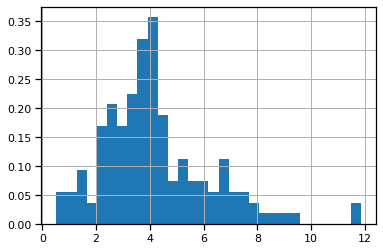

In [8]:
precip.Apr.hist(normed=True, bins=30)

### Exercise 1:

Start with the `Uniform` distribution. Rainfall for the month of April seems to go from 0 to 12 units, so we'll pick the appropriate parameters for our Uniform distribution to capture all the data.

This is the modeling part:

```python
from pymc3 import Model, Uniform

with Model() as rainfall_model:
    ualpha = Uniform('ualpha', lower=0, upper=15)
    ubeta = Uniform('ubeta', lower=0, upper=15)
    
with rainfall_model:
    april_like = Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)
```

This is the simulation part (be patient):
```python
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)
```

And this is how we get our posterior pdfs:
```python
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');
```

Then let's see if our posterior model matches our histogram:

We can use the `gamma.pdf` function in `scipy.stats.distributions` to plot the distributions implied by the calculated alphas and betas. Yes, yes, I know, we have not introduced scipy official yet..

</br >
<center>
<img src="https://c402277.ssl.cf1.rackcdn.com/photos/14785/images/story_full_width/shutterstock_532108075.jpg" width=400 />
Lazy Professor!
</center>

```python
from scipy.stats.distributions import gamma

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))
```

### Exercise 2:

Does the Uniform distribution work out?

Now try the `Normal` distribution. Please make sure to introduce **new** variables for your priors (xxxalpha, xxxbeta), as well as your simulation trace (xxxapril_like).

What's the right support for the normal? Pick a mean that centers the gaussian around the peak of the month, and a standard deviation that allows the gaussian to cover all the data.

### Exercise 3: 

Let's try to accelerate things and try the exponential distribution. Find the right number x so that the distribution covers the range of precipitation.  In other words, find the right value $y$ such that `Exponential.dist(1/3).random(size=10000)` covers from 0 to 12 for the month of April. Try different values out by plotting with:

```python
sns.distplot(Exponential.dist(1/3).random(size=10000), kde=False);
```


### Exercise 4:

Do the month of January.

### (Thinking) Exercise 5:

How would you do *all* months together?

### Solution

A support of the exponential in the range \[0,10\]?

In [13]:
from pymc3 import Model, Exponential

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\liaoz\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


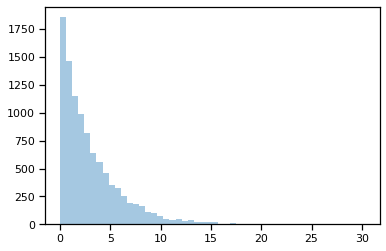

In [14]:
sns.distplot(Exponential.dist(1/3).random(size=10000), kde=False);

In [15]:
with Model() as rainfall_model:
    ealpha = Exponential('ealpha', 1/3.)
    ebeta = Exponential('ebeta', 1/3.)

In [16]:
from pymc3 import Gamma

with rainfall_model:
    april_like = Gamma('april_like', alpha=ealpha, beta=ebeta, observed=precip.Apr)

In [17]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 317.35: 100%|████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 135.26it/s]
Finished [100%]: Average Loss = 317.21


C:\Users\liaoz\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


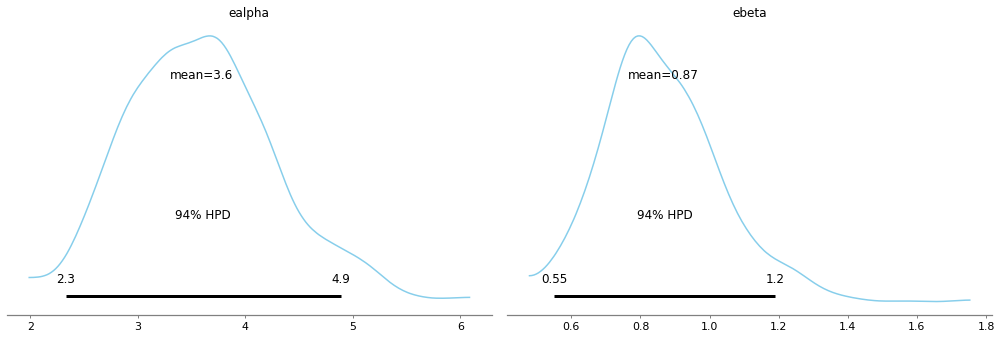

In [18]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ealpha', 'ebeta'],
                color='#87ceeb');

C:\Users\liaoz\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


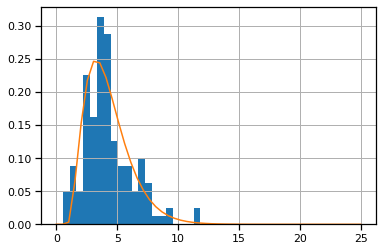

In [19]:
from scipy.stats.distributions import gamma

precip.Apr.hist(normed=True, bins=20)
#plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), 9.266, 2.302))
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), 3.4, 0.865))

Nice fit :-)

Now let's do the month of January.

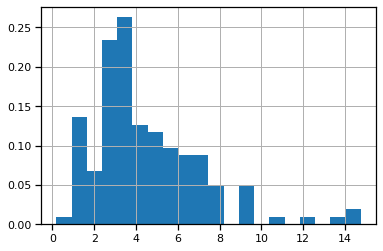

In [20]:
precip.Jan.hist(normed=True, bins=20)

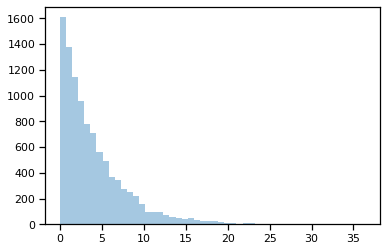

In [21]:
sns.distplot(Exponential.dist(1/4).random(size=10000), kde=False);

In [22]:
with Model() as rainfall_model:
    #nalpha = Normal('palpha', 2, sd=1)
    #nbeta = Normal('pbeta', 0.5, sd=1)
    ealpha8 = Exponential('ealpha8', 1/4.)
    ebeta8 = Exponential('ebeta8', 1/4.)

In [23]:
with rainfall_model:
    jan8_like = Gamma('jan8_like', alpha=ealpha8, beta=ebeta8, observed=precip.Jan)

In [24]:
with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 350.32: 100%|████████████████████████████████████████████████████| 10000/10000 [01:14<00:00, 134.97it/s]
Finished [100%]: Average Loss = 350.14


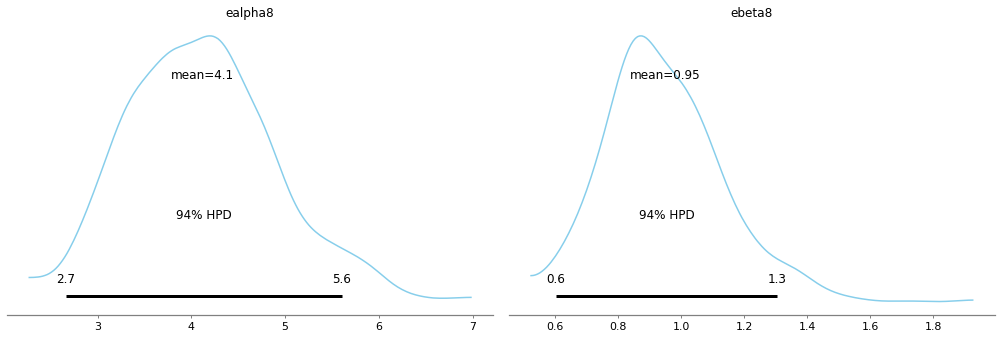

In [25]:
plot_posterior(rainfall_trace[100:], 
                varnames=['ealpha8', 'ebeta8'],
                color='#87ceeb');

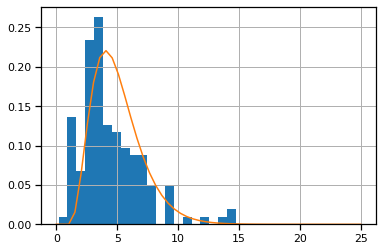

In [26]:
precip.Jan.hist(normed=True, bins=20)
#plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), 9.266, 2.302))
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), 4.1, 0.948))